In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
class net(torch.nn.Module):
    def __init__(self, base_model, base_out_features, num_classes):
        super(net,self).__init__()
        self.base_model=base_model
        self.linear1 = torch.nn.Linear(base_out_features, 512)
        self.output = torch.nn.Linear(512,num_classes)
    def forward(self,x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.linear1(x))
        x = self.output(x)
        return x

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [4]:
res = torchvision.models.resnet50(pretrained=True)
for param in res.parameters():
    param.requires_grad=False

model_best = net(base_model=res, base_out_features=res.fc.out_features, num_classes=80)
model_best = model_best.to(device)

model_worst = net(base_model=res, base_out_features=res.fc.out_features, num_classes=80)
model_worst = model_worst.to(device)


In [ ]:
model_best.load_state_dict(torch.load('/content/drive/MyDrive/졸업논문/data/model/best_model.pth', map_location=device))
model_best.eval()
model_worst.load_state_dict(torch.load('/content/drive/MyDrive/졸업논문/data/model/worst_model.pth', map_location=device))
model_worst.eval()

In [7]:
!mkdir 'test_cat_img'
!mkdir 'test_dog_img'

In [ ]:
!unzip /content/drive/MyDrive/졸업논문/data/test_case/cat_test.zip -d /content/test_cat_img/
!unzip /content/drive/MyDrive/졸업논문/data/test_case/dog_test.zip -d /content/test_dog_img/

In [6]:
test_cat_list = os.listdir('./test_cat_img')
test_dog_list = os.listdir('./test_dog_img')

In [7]:
dir_cat = './test_cat_img'
dir_dog = './test_dog_img'
test_cat_img = {'img':test_cat_list}
test_cat_img = pd.DataFrame(test_cat_img)
test_cat_img.img = test_cat_img.img.apply(lambda x:dir_cat+'/'+x)
test_dog_img = {'img':test_dog_list}
test_dog_img = pd.DataFrame(test_dog_img)
test_dog_img.img = test_dog_img.img.apply(lambda x:dir_dog+'/'+x)

In [8]:
class setting(Dataset):
    def __init__(self,dataframe,transform):
        self.dataframe = dataframe
        self.transform = transform
        
    def __getitem__(self,index):
        x = Image.open(self.dataframe.iloc[index,0]).convert('RGB')
        x = self.transform(x)
        return x
        
    def __len__(self):
        return self.dataframe.shape[0]

In [9]:
transformer = transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [10]:
test_cat_dataset = setting(test_cat_img,transform=transformer)
test_cat_loader = DataLoader(test_cat_dataset)

test_dog_dataset = setting(test_dog_img,transform=transformer)
test_dog_loader = DataLoader(test_dog_dataset)

In [11]:
nu = 1000

def softmax(x):
  softmax = torch.nn.Softmax(dim=1)
  return softmax(x)

def reverse_sigmoid(z,nu):
  return 1/(1+torch.exp(nu*z))

def ood_detector(expected_value,tau):
  global nu
  msp = softmax(expected_value)
  max = torch.max(msp)
  return reverse_sigmoid(max-tau,nu)

def AM(f,f_hat,tau):
  alpha = ood_detector(f,tau)
  return (1-alpha)*f + alpha*f_hat


In [12]:
def sim(a,b):
  x = np.array(a) - np.array(b)
  return (len(x)-np.count_nonzero(x))/len(x)

In [13]:
def testing(test_loader,tau):
  output_original=[]
  output_mislabeled=[]

  for x in test_loader:
    x = x.to(device)
    f = model_best(x)
    f_hat = model_worst(x)
    y_hat = AM(f,f_hat,tau)
    _,predicted = torch.max(y_hat.data, 1)
    predicted = predicted.cpu()
    index = predicted.numpy()[0]
    output_mislabeled.append(index)
    _,predicted = torch.max(f.data, 1)
    predicted = predicted.cpu()
    index = predicted.numpy()[0]
    output_original.append(index)
  
  return sim(output_original,output_mislabeled)

In [14]:
tau = np.arange(0.1,1,0.1)
output_cat = []
output_dog = []
for i in tau:
  output_cat.append(testing(test_cat_loader,i))
  output_dog.append(testing(test_dog_loader,i))

In [22]:
print(output_cat)
print(output_dog)

[0.9920870425321464, 0.811078140454995, 0.579624134520277, 0.39663699307616224, 0.26409495548961426, 0.19881305637982197, 0.1414441147378833, 0.08506429277942631, 0.04451038575667656]
[0.9980217606330366, 0.9742828882294757, 0.9060336300692384, 0.7754698318496538, 0.6646884272997032, 0.5361028684470821, 0.4332344213649852, 0.31948565776458954, 0.2215628090999011]


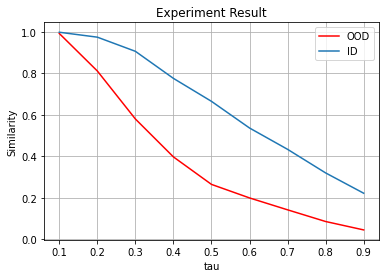

In [21]:
import matplotlib.pyplot as plt

plt.plot(tau,output_cat,'r')
plt.plot(tau,output_dog)
plt.grid(True)
plt.xlabel('tau')
plt.ylabel('Similarity')
plt.title('Experiment Result')
plt.legend(['OOD','ID'])
plt.show()